# Twitter Sentiment Analysis (Parte 1)

A construção da rede neural, que vou utilizar na parte 2, foi baseada em uma aula que tive da Udacity, do "PyThorch Scholarship Challenge", no qual aprendi sobre redes neurais profundas (CNNs, LSTMs, etc.). 

O meu objetivo nessa primeira parte vai fazer uma análise exploratória dos dados pra então treinar um algoritmo, na parte 2, capaz de classificar os sentimentos desses twittes, que são dividos em três categorias, sendo elas:

1 - Negativos: qualquer tuíte relacionado com algum sentimento ruim, negativo, de estresse, ou que sejam contra a quarentena;

2 - Neutros: caem nessa categoria os tts de propaganda, os que tem um sentimento neutro em relação a quarentena, relatos de atividades cotidianas;

3 - Positivos: expressam um sentimento positivo em relação a quarentena, ou piadas, brincadeiras, dicas, etc.

Também influenciou a minha nota quando um determinado tuíte aparentava que seu autor poderia vir logo a aparentar sintomas negativos, relacionados ao tédio de ter que ficar em casa.

In [1]:
import re
from baseuf import ufbr
from collections import Counter
import csv
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

## Informações básicas sobre os dados

In [2]:
# Abrindo os arquivos:
csvFile = str(input(">>> Enter file name: "))
data = pd.read_csv(csvFile)
data.drop(columns=['Unnamed: 0'], inplace=True)

>>> Enter file name: quarentenaBR.csv


/home/laisouzalves/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,date,geo,hashtags,id,place,text
0,Thu Apr 02 20:45:17 +0000 2020,NaN,"quarentena, personalidade, engracado",1245814582364516355,Falha na localização 🚫,Eu tirei: Anti-social🙂! E você? https://t.co/s...
1,Thu Apr 02 20:45:14 +0000 2020,NaN,"animalhouse, quarentena, movietime",1245814571559989258,Portugal,Bute ver um filme? #animalhouse #quarentena #m...
2,Thu Apr 02 20:45:12 +0000 2020,NaN,isolamentosocial,1245814563741798401,NaN,Hoje voltei a meditar... Tá foda. #isolamentos...
3,Thu Apr 02 20:45:12 +0000 2020,"[[-35.815834, -9.711808], [-35.558391, -9.7118...","quarentena, TikTok",1245814560851931136,"Maceió, Alagoas",A minha #quarentena está resumida nesse vídeo....
4,Thu Apr 02 20:45:09 +0000 2020,NaN,"humor, comedia, quarentena",1245814550630486017,NaN,RT @Vamosrirsualou1: Eu estou iguaizinho kkk\n...


In [29]:
data.tail()

,date,geo,hashtags,id,place,text
614751,2020-03-18 22:22,NaN,NaN,"1,24044859183722E+018",NaN,"Anitta, rainha brasileira! Proporcionando bem ..."
614752,2020-03-18 22:22,NaN,NaN,"1,24044845673451E+018",NaN,Esse vídeo mostra como podemos ajudar a diminu...
614753,2020-03-18 22:22,NaN,NaN,"1,24044843663541E+018",NaN,Me deem dicas de não engordar 20 kgs nessas fé...
614754,2020-03-18 22:22,NaN,NaN,"1,24044840409179E+018",NaN,Ponto alto do meu 2º dia de # quarentena : liv...
614755,2020-03-18 22:21,NaN,NaN,"1,24044836615006E+018",NaN,Ai gente eu pensei que ia estudar mais nessa #...


In [4]:
# df = data[['id', 'date', 'text', 'geo', 'hashtags', 'place']]

# "Little" Exploratory Data Analysis (EDA)

In [5]:
total_twittes = data.shape[0]
print("O total de twittes é de {}.".format(total_twittes))

O total de twittes é de 614756.


## Quantas coordenadas preenchidas

In [6]:
num_coord = data['geo'].notnull().sum()
print('Total de twittes com Coordenadas não-nulas: {}\nIsso equivale à {:.2f}% do número total de twittes.'.format(num_coord, num_coord/total_twittes*100))

Total de twittes com Coordenadas não-nulas: 25046
Isso equivale à 4.07% do número total de twittes.


In [7]:
# Salvando as coordenadas em uma lista
mask1 = data['geo'].notnull()
geo_coord = data[mask1]

# mask2 = geo_coord['has_place'] == False
# geo_and_local = geo_coord[mask2]

geo_coord_list = pd.DataFrame(geo_coord['geo'])
# geo_coord_list.to_csv('coordenadas_tts.csv')

In [8]:
geo_coord_list.head()

,geo
3,"[[-35.815834, -9.711808], [-35.558391, -9.7118..."
25,"[[-46.826039, -24.008814], [-46.365052, -24.00..."
32,"[[-40.969461, -9.482947], [-40.208561, -9.4829..."
46,"[[-49.3916434, -25.6447517], [-49.1852775, -25..."
68,"[[-8.916355, 42.1293801], [-8.6267592, 42.1293..."


## Quantos Locais válidos únicos existem

In [14]:
accent_map = {u'\u00c0': u'A', u'\u00c1': u'A', u'\u00c2': u'A', u'\u00c3': u'A', u'\u00c4': u'A', u'\u00c5': u'A', u'\u00c6': u'A', u'\u00c7': u'C', u'\u00c8': u'E', u'\u00c9': u'E', u'\u00ca': u'E', u'\u00cb': u'E', u'\u00cc': u'I', u'\u00cd': u'I', u'\u00ce': u'I', u'\u00cf': u'I', u'\u00d0': u'D', u'\u00d1': u'N', u'\u00d2': u'O', u'\u00d3': u'O', u'\u00d4': u'O', u'\u00d5': u'O', u'\u00d6': u'O', u'\u00d7': u'x', u'\u00d8': u'0', u'\u00d9': u'U', u'\u00da': u'U', u'\u00db': u'U', u'\u00dc': u'U', U'\u00dd': u'Y', u'\u00df': u'B', u'\u00e0': u'a', u'\u00e1': u'a', u'\u00e2': u'a', u'\u00e3': u'a', u'\u00e4': u'a', u'\u00e5': u'a', u'\u00e6': u'a', u'\u00e7': u'c', u'\u00e8': u'e', u'\u00e9': u'e', u'\u00ea': u'e', u'\u00eb': u'e', u'\u00ec': u'i', u'\u00ed': u'i', u'\u00ee': u'i', u'\u00ef': u'i', u'\u00f1': u'n', u'\u00f2': u'o', u'\u00f3': u'o', u'\u00f4': u'o', u'\u00f5': u'o', u'\u00f6': u'o', u'\u00f8': u'0', u'\u00f9': u'u', u'\u00fa': u'u', u'\u00fb': u'u', u'\u00fc': u'u'}


def accent_remove(m):
    return accent_map[m.group(0)]


def clean_list(list_to_clean):
    for idx, item in enumerate(list_to_clean):
        list_to_clean[idx] = str(item)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('[÷ð]', '', string)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub(u'([\u00C0-\u00FC])', accent_remove, string.encode().decode('utf-8'))
        list_to_clean[idx] = list_to_clean[idx].lower()
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('\W\s-', '', string)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('[…•\(\)\&]', ' ', string)
    return list_to_clean


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def clean_tts(list_to_clean):
    for idx, item in enumerate(list_to_clean):
        # transforma tudo para str
        list_to_clean[idx] = str(item)
        # retira todo o link https:// do tuite
        list_str = list_to_clean[idx].split()
        string = ' '.join([word for word in list_str if not re.search('https://t.co', word)])
        #remove acentos
        list_to_clean[idx] = re.sub(u'([\u00C0-\u00FC])', accent_remove, string.encode().decode('utf-8'))
        # remove emojis
        string = list_to_clean[idx].encode('ascii', 'ignore').decode('ascii')
        list_to_clean[idx] = remove_emoji(string)
        # deixa tudo em caixa baixa
        list_to_clean[idx] = list_to_clean[idx].lower()
        # substitui o restante dos caracteres desnecessarios
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('[…•\(\)\&]', '', string)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('\W\s-', '', string)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('["º°/_]', ' ', string)
        # remove espaços desnecessarios
        string_list = list_to_clean[idx].split()
        list_to_clean[idx] = ' '.join(string_list)

    return list_to_clean

def filter_count(principal_list, filter1):
    count_filter = 0
    bool_list = []
    for idx, item in enumerate(principal_list):
        frase = item
        if ' - ' in frase:
            frase = frase.split(' - ')
        elif ' -' in frase:
            frase = frase.split(' -')
        elif '- ' in frase:
            frase = frase.split('- ')
        elif '-' in frase:
            frase = frase.split('-')
        elif ' / ' in frase:
            frase = frase.split(' / ')
        elif ' /' in frase:
            frase = frase.split(' /')
        elif '/ ' in frase:
            frase = frase.split('/ ')
        elif '/' in frase:
            frase = frase.split('/')
        elif ' , ' in frase:
            frase = frase.split(' , ')
        elif ', ' in frase:
            frase = frase.split(', ')
        elif ' ,' in frase:
            frase = frase.split(' ,')
        elif ',' in frase:
            frase = frase.split(',')
        elif ' | ' in frase:
            frase = frase.split(' | ')
        elif ' |' in frase:
            frase = frase.split(' |')
        elif '| ' in frase:
            frase = frase.split('| ')
        elif '|' in frase:
            frase = frase.split('|')
        
        if type(frase) != list:
            frase = [frase]
            
        for idx, item in enumerate(filter1):
            if item in frase:
                count_filter += 1
                bool_list.append(True)
                break
            if item == filter1[-1]:
                bool_list.append(False)

    return count_filter, bool_list


# def cities_tolist(city_list):
#     cities = []
#     for idx, item in enumerate(city_list):
#         city = item.lower()
#         cities.append(city)
#     return cities


estados = [['acre', 'ac'], ['alagoas', 'al'], ['amazonas', 'am'], ['amapa', 'ap'], ['bahia', 'bahea', 'ba'],  ['ceara', 'ce'], ['distrito federal', 'de-efe', 'brasolia', 'df', 'taguatinga', 'asa sul', 'sobradinho', 'ceilandia', 'samambaia', 'asa norte', 'guara', 'aguas claras', 'parkway', 'vicente pires'], ['espirito santo', 'es'], ['goias', 'gyn', 'go'], ['maranhao', 'terehell', 'ma'], ['minas gerais', 'mg'], ['mato grosso do sul', 'ms'], ['mato grosso', 'mt'], ['para', 'pa'], ['paraiba', 'pb'], ['pernambuco', 'pe'], ['piaui', 'pi'], ['parana', 'pr'], ['rio de janeiro', 'rj'], ['rio grande do norte', 'rn'], ['rondonia', 'ro'], ['roraima', 'rr'], ['rio grande do sul', 'rs'], ['santa catarina', 'sc'], ['sergipe', 'se'], ['sao paulo', 'sampa', 'sp'], ['tocantins', 'to']]

def separar_estados(lista_locais, csvFile_):
    c_lista_locais = clean_list(lista_locais)
    dataframe = pd.DataFrame(columns=['state', 'tts_count'])
    # ufbr.list_uf = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']
    for idx, item in enumerate(ufbr.list_uf):
        # Example: cidades_sp = ufbr.list_cidades('SP')
        # cities_tolist() limpa a lista de cidades (set lower)
        # cities = cities_tolist(ufbr.list_cidades(item)) + estados[idx]
        cities = [x.lower() for x in ufbr.list_cidades(item)] + estados[idx]
        # c_cities contains the list of cities without any pontuation
        c_cities = clean_list(cities)
        # cities_count(states_list) é o numero de tweets na lista states_list
        cities_count, has_place_list = filter_count(c_lista_locais, c_cities)
        row_to_append = [str(item), cities_count]
        row = pd.DataFrame([row_to_append], columns=['state', 'tts_count'])
        dataframe = dataframe.append(row, ignore_index=True)

    dataframe.to_csv(csvFile_, mode='a', columns=['state', 'tts_count'], header=True, index=False, encoding="utf-8")


In [17]:
estados_list = ['acre', 'ac', 'alagoas', 'al', 'amapa', 'ap', 'amazonas', 'am', 'bahia', 'ba', 'ceara', 'ce', 'distrito federal', 'df', 'espirito santo', 'es', 'goias', 'go', 'maranhao', 'ma', 'mato grosso', 'mt', 'mato grosso do sul', 'ms', 'minas gerais', 'mg', 'para', 'pa', 'paraiba', 'pb', 'parana', 'pr', 'pernambuco', 'pe', 'piaui', 'pi', 'rio de janeiro', 'rj', 'rio grande do norte', 'rn', 'sul', 'rs', 'rondonia', 'ro', 'roraima', 'rr', 'santa catarina', 'sc', 'sao paulo', 'sp', 'sergipe', 'se', 'tocantins', 'to']

capitais = ['rio branco', 'maceio', 'macapa', 'manaus', 'salvador', 'fortaleza', 'brasilia', 'bsb', 'vitoria', 'goiania', 'gyn', 'sao luis', 'cuiaba', 'campo grande', 'belo horizonte', 'bh', 'belem', 'joao pessoa', 'jp', 'curitiba', 'recife', 'teresina', 'terehell', 'rio de janeiro', 'rj', 'natal', 'porto alegre', 'poa', 'porto velho', 'boa vista', 'florianopolis', 'floripa', 'sao paulo', 'sampa', 'aracaju', 'palmas']

print("Colecting all cities in Brasil...")
all_cities = []
for item in ufbr.list_uf:
    city_list = [x.lower() for x in ufbr.list_cidades(item)]
    all_cities += city_list
print("Done colecting all cities.\n")

# all_cities = []    
# for idx, item in enumerate(ufbr.list_uf):
#     city_list = cities_tolist(ufbr.list_cidades(item))
#     for idx, item in enumerate(city_list):
#         all_cities.append(item)

print("Cleaning lists...")
locais_br = all_cities + estados_list + ['brasil', 'brazil']
c_locais_br = clean_list(locais_br)

places = data['place'].to_list()
c_places = clean_list(places)
print("Done cleaning lists.\n")

# places_idx = []
# places_bool = []
# for idx, item in enumerate(c_places):
#     string = str(item)
#     for i, j in enumerate(string.split()): 
#         if j in c_locais_br:
#             places_bool.append(True)
#             places_idx.append(idx)
#             break
#         else: 
#             places_bool.append(False)
#
# OU ESSA VERSÃO ABAIXO QUE É MAIS EFICIENTE
#
# print("Colecting 'has_place' column...")
# places_bool = [True if item in c_locais_br else False for item in c_places]
# print("Done colecting 'has_place' column. /nNow colecting places indexes...")
# places_idx = [idx for idx, item in enumerate(c_places) if item in c_locais_br]
# print("Done colecting places indexes.")

# Mas melhor ainda é o código abaixo. Eu corrigi a funçao filter_count() pra coletar a coluna True/False
print("Colecting 'has_place' column...")
num_places_br, has_place = filter_count(c_places, c_locais_br)
print("Done colecting 'has_place' column.")

mask = data['place'].notnull()
data_all_places = data[mask]

print("Número total de tweets com local preenchido {}.\nIsso equivale a {:.2f} % dos tweets.\n".format(data_all_places.shape[0], data_all_places.shape[0]*100/data.shape[0]))

# print("Número total de twittes que possuem local válido: {}.\nIsso equivale à {:.2f}% do total de twittes.".format(len(places_idx), len(places_idx)*100/len(c_places)))
print("Número total de twittes que possuem local válido: {}.\nIsso equivale à {:.2f}% do total de twittes.".format(num_places_br, num_places_br*100/data.shape[0]))

Colecting all cities in Brasil...
Done colecting all cities.

Cleaning lists...
Done cleaning lists.

Colecting 'has_place' column...
Done colecting 'has_place' column.
Número total de tweets com local preenchido 406726.
Isso equivale a 66.16 % dos tweets.

Número total de twittes que possuem local válido: 300470.
Isso equivale à 73.88% do total de twittes.


In [19]:
# O código abaixo já não é mais necessário pq essa funcionalidade foi inserida na função filter_count()
# has_place = list(range(0, len(data['place'])))
# for idx,item in enumerate(data['place']):
#     if idx in places_idx:
#         has_place[idx] = True
#     else:
#         has_place[idx] = False


has_place = pd.DataFrame(has_place, columns=['has_place'])
new_data = pd.concat([data, has_place], axis=1)
print(">>> New column 'has_place' has been concatenated")
try:
    if new_data['Unnamed: 0'].any():
        print('---------------------------------------------------------')
        print("Droping column 'Unnamed: 0'")
        new_data.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    pass

>>> New column 'has_place' has been concatenated


In [20]:
new_data.head(50)

,date,geo,hashtags,id,place,text,has_place
0,Thu Apr 02 20:45:17 +0000 2020,NaN,"quarentena, personalidade, engracado",1245814582364516355,Falha na localização 🚫,Eu tirei: Anti-social🙂! E você? https://t.co/s...,False
1,Thu Apr 02 20:45:14 +0000 2020,NaN,"animalhouse, quarentena, movietime",1245814571559989258,Portugal,Bute ver um filme? #animalhouse #quarentena #m...,False
2,Thu Apr 02 20:45:12 +0000 2020,NaN,isolamentosocial,1245814563741798401,NaN,Hoje voltei a meditar... Tá foda. #isolamentos...,False
3,Thu Apr 02 20:45:12 +0000 2020,"[[-35.815834, -9.711808], [-35.558391, -9.7118...","quarentena, TikTok",1245814560851931136,"Maceió, Alagoas",A minha #quarentena está resumida nesse vídeo....,True
4,Thu Apr 02 20:45:09 +0000 2020,NaN,"humor, comedia, quarentena",1245814550630486017,NaN,RT @Vamosrirsualou1: Eu estou iguaizinho kkk\n...,False
5,Thu Apr 02 20:45:09 +0000 2020,NaN,NaN,1245814549346955271,NaN,RT @jorgeemateus: Vamos de spoiler? Essas já e...,False
6,Thu Apr 02 20:45:07 +0000 2020,NaN,"sunshine, raiodesol, vsco, vscofilters, Quaren...",1245814540127940608,se eu soubesse eu falava,Eh O prisioneiro saiu pra pegar um banho de so...,False
7,Thu Apr 02 20:45:07 +0000 2020,NaN,"coronavirusnomundo, quarentena, covid19",1245814539842715648,NaN,RT @Francischini_: Previsão da OMS se confirmo...,False
8,Thu Apr 02 20:45:06 +0000 2020,NaN,"EcuadorEnEmergencia, COVID19Pandemic, quarente...",1245814536235560961,Brasil,Ver a situação do Equador neste momento acabou...,True
9,Thu Apr 02 20:44:50 +0000 2020,NaN,NaN,1245814472146595842,NaN,RT @JL2edicao: Corpo de homem que foi desenter...,False


In [22]:
# DataFrame with all the valid places:
mask = new_data['has_place'] == True
data_valid_places = new_data[mask]

# List with all valid places:
places_list = data_valid_places['place'].to_list()

# csvFile_places = str(input(">>> Enter name for the output csv file for the number of tweets per state (ex.: tweets-per-state.csv): "))
csvFile_places = 'tts-por-estado.csv'
separar_estados(places_list, csvFile_places)

count = pd.read_csv(csvFile_places) # tts-por-estado.csv
number_of_tts = count['tts_count'].sum()

print("Total de tweets com 'place' do Brasil: {}".format(number_of_tts))


---------------------------------------------------------

Total de tweets com 'place' do Brasil: 284760


In [23]:
data_valid_places.shape[0]

300470

## Análise de RTs

In [24]:
tweets = new_data['text'].tolist()
tweets = [str(x) for x in tweets]

tweets_RT = sum(1 for x in tweets if x.count('RT @'))

print("Total de RTs : {}".format(tweets_RT))
print("Isso equivale a {:.2f}% do número total de tweets.".format(tweets_RT*100/len(tweets)))
print('---------------------------------------------------------')


is_rt = []
rt_pattern = 'RT @'
original_tts = new_data['text'].tolist()
for idx, item in enumerate(original_tts):
    string = str(item)
    if string.find(rt_pattern) == 0:
        is_rt.append(True)
    else:
        is_rt.append(False)

is_rt = pd.DataFrame(is_rt, columns=['is_rt'])
new_data_rt = pd.concat([new_data, is_rt], axis=1)
print(">>> New column 'is_rt' has been concatenated")
try:
    if new_data_rt['Unnamed: 0'].any():
        print('---------------------------------------------------------')
        print(">>> Droping column 'Unnamed: 0'")
        new_data_rt.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    pass

Total de RTs : 363424
Isso equivale a 59.12% do número total de tweets.
---------------------------------------------------------
>>> New column 'is_rt' has been concatenated


In [25]:
fileName = str(csvFile[:-4]+'_new.csv')
new_data_rt.to_csv(fileName)
print(">>> New file '{}' has been created.".format(fileName))

>>> New file 'quarentenaBR_new.csv' has been created.


In [26]:
new_data_rt.shape

(614756, 8)

In [27]:
new_data_rt.head(50)

,date,geo,hashtags,id,place,text,has_place,is_rt
0,Thu Apr 02 20:45:17 +0000 2020,NaN,"quarentena, personalidade, engracado",1245814582364516355,Falha na localização 🚫,Eu tirei: Anti-social🙂! E você? https://t.co/s...,False,False
1,Thu Apr 02 20:45:14 +0000 2020,NaN,"animalhouse, quarentena, movietime",1245814571559989258,Portugal,Bute ver um filme? #animalhouse #quarentena #m...,False,False
2,Thu Apr 02 20:45:12 +0000 2020,NaN,isolamentosocial,1245814563741798401,NaN,Hoje voltei a meditar... Tá foda. #isolamentos...,False,False
3,Thu Apr 02 20:45:12 +0000 2020,"[[-35.815834, -9.711808], [-35.558391, -9.7118...","quarentena, TikTok",1245814560851931136,"Maceió, Alagoas",A minha #quarentena está resumida nesse vídeo....,True,False
4,Thu Apr 02 20:45:09 +0000 2020,NaN,"humor, comedia, quarentena",1245814550630486017,NaN,RT @Vamosrirsualou1: Eu estou iguaizinho kkk\n...,False,True
5,Thu Apr 02 20:45:09 +0000 2020,NaN,NaN,1245814549346955271,NaN,RT @jorgeemateus: Vamos de spoiler? Essas já e...,False,True
6,Thu Apr 02 20:45:07 +0000 2020,NaN,"sunshine, raiodesol, vsco, vscofilters, Quaren...",1245814540127940608,se eu soubesse eu falava,Eh O prisioneiro saiu pra pegar um banho de so...,False,False
7,Thu Apr 02 20:45:07 +0000 2020,NaN,"coronavirusnomundo, quarentena, covid19",1245814539842715648,NaN,RT @Francischini_: Previsão da OMS se confirmo...,False,True
8,Thu Apr 02 20:45:06 +0000 2020,NaN,"EcuadorEnEmergencia, COVID19Pandemic, quarente...",1245814536235560961,Brasil,Ver a situação do Equador neste momento acabou...,True,False
9,Thu Apr 02 20:44:50 +0000 2020,NaN,NaN,1245814472146595842,NaN,RT @JL2edicao: Corpo de homem que foi desenter...,False,True


## Lista para nuvem de palavras

In [30]:
mask = new_data_rt['is_rt'] == False
cloud_data = new_data_rt[mask]
mask = cloud_data['has_place'] == True
cloud_data = cloud_data[mask]

clean_tuites = cloud_data['text'].to_list()
clean_tuites = clean_tts(clean_tuites)

word_list = []
stop_words = ['e', 'de', 'a', 'as', 'da', 'das', 'o', 'os', 'aos', 'do', 'dos', 'que', 'em', 'com', 'para', 'n', 'no', 'na', 'um', 'se', 'pra', 'este', 'esta', 'pro', 'me', 'ao', 'ou', 'esse', 'essa', 'q', 'p', 'nas', 'pq', 'tao', 'entao', 'te', 'porque', '1', '2', '3', '4', '5', '7', '10', '...', '.', ',', '?', '!', '|', ':', '#', '@']
print(">>> Saving file 'nuvem_palavras.txt'...")
with open('nuvem_palavras.txt', 'w') as wf:
    for phrase in clean_tuites:
        for word in phrase.split():
            if word not in stop_words:
                if word[-1] == '.' or word[-1] == ',':
                    word_list.append(str(word[:-1]))
                else:
                    word_list.append(str(word))
                wf.write(word + ' ')

words_count = Counter(word_list)
df_words_count = pd.DataFrame(words_count.items(), columns=['word', 'count'])
df_words_count = df_words_count.sort_values(by=['count'], ascending=False).reset_index(drop=True)
print(">>> Saving file 'words_count.csv'...")
df_words_count.to_csv('words_count.csv')

>>> Saving file 'nuvem_palavras.txt'...
>>> Saving file 'words_count.csv'...


## Plotting number of tweets per day

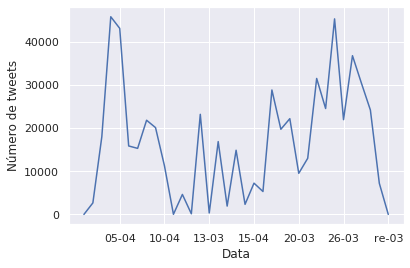

In [59]:
dates = new_data_rt['date'].to_list()

clean_datas = []
for idx, item in enumerate(dates):
    string = str(item)
    day = string[8:10]
    month = string[4:7]
    if month == 'Apr':
        month = '04'
        clean_datas.append('{}-{}'.format(day, month))
    else:
        month = '03'
        clean_datas.append('{}-{}'.format(day, month))

counts = Counter(clean_datas)
df_num_tts = pd.DataFrame(counts.items(), columns=['date', 'num_tts'])
df_num_tts.drop([0, 36], axis=0, inplace=True)
df_num_tts = df_num_tts.sort_values(by=['date']).reset_index(drop=True)

sns_plot = sns.lineplot(x="date", y="num_tts", data=df_num_tts)
sns_plot.set(xticks=[4, 9, 14, 19, 24, 29, 34])
sns_plot.set(xlabel="Data", ylabel = "Número de tweets")
fig = sns_plot.get_figure()
fig.savefig("tweets_per_day.png")

In [60]:
df_num_tts.head(50)

,date,num_tts
0,-03,3
1,01-04,2666
2,03-04,17999
3,04-04,45797
4,05-04,43100
5,06-04,15862
6,07-04,15304
7,08-04,21821
8,09-04,20111
9,10-04,11228


In [71]:
date = ['03-11', '03-12', '03-13', '03-14', '03-15', '03-16', '03-17', '03-18', '03-19', '03-20', '03-22', '03-23', '03-24', '03-25', '03-26', '03-27', '03-28', '03-29', '03-30', '04-01', '04-02', '04-03', '04-04', '04-05', '04-06', '04-07', '04-08', '04-09', '04-10', '04-11', '04-12', '04-13', '04-14', '04-15']
num_tts = [30, 147, 334, 1933, 2337, 5310, 28828, 19731, 22183, 9522, 12798, 13006, 31503, 24539, 45305, 21953, 36773, 30404, 24191, 7202, 2666, 16021, 17999, 45797, 43100, 15862, 15304, 21821, 20111, 11228, 4632, 23191, 14870, 7244]

In [72]:
print(len(date), len(num_tts))

34 34


In [73]:
df_num_tts = pd.DataFrame(columns=['date', 'num_tts'])
for i, j in zip(date, num_tts):
    row_to_app = [str(i), int(j)]
    row = pd.DataFrame([row_to_app], columns=['date', 'num_tts'])
    df_num_tts = df_num_tts.append(row, ignore_index=True)
df_num_tts.head(50)

,date,num_tts
0,03-11,30
1,03-12,147
2,03-13,334
3,03-14,1933
4,03-15,2337
5,03-16,5310
6,03-17,28828
7,03-18,19731
8,03-19,22183
9,03-20,9522


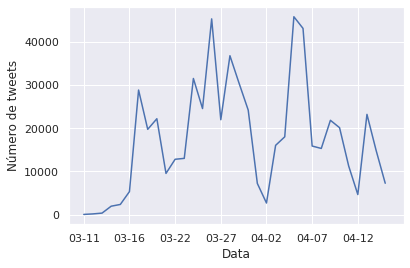

In [78]:
sns_plot = sns.lineplot(x=date, y=num_tts)
sns_plot.set(xticks=[0, 5, 10, 15, 20, 25, 30, 35])
sns_plot.set(xlabel="Data", ylabel = "Número de tweets")
fig = sns_plot.get_figure()
fig.savefig("tweets_per_day.png")

## Twittes com local e originais (não sao RTs)

### Rapidamente, vou verificar quais os 'ids' não estão corretos

## Selecionando twittes para treino:

## Limpando os tuites para a nuvem de palavras

## Gráfico do número de twittes por dia com a hashtag #quarentena